<a href="https://colab.research.google.com/github/jyj1206/SoloDeepLearning/blob/main/Chapter5_Handling_Visualization_of_'Many'_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 json, hashlib 튜토리얼

In [ ]:
import json
a = {'value' : 5, 'value2': 10, 'seq' : [1, 2, 3, 4, 5]}

filename = 'test.json'
with open(filename, 'w') as f:
  json.dump(a, f)

with open(filename, 'r') as f:
  result = json.load(f)
  print(result)

{'value': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [ ]:
!ls
!cat test.json

data  results  sample_data  test.json
{"value": 5, "value2": 10, "seq": [1, 2, 3, 4, 5]}

In [ ]:
import hashlib
setting = {'value' : 5, 'value2': 10, 'seq' : [1, 2, 3, 4, 5], 'exp_name' : 'exp1'}

exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
filename = f'{exp_name}-{hash_key}.json'
print(filename)

exp1-8ad3bc.json


## seaborn 튜토리얼

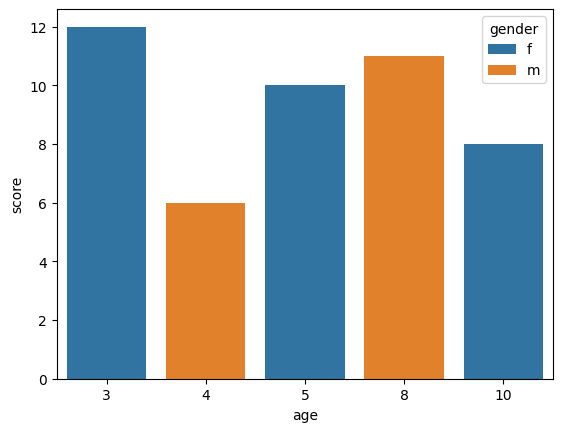

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


a = [
    {'age': 5, 'gender': 'f', 'score': 10, 't': 1},
    {'age': 4, 'gender': 'm', 'score': 6, 't': 2},
    {'age': 8, 'gender': 'm', 'score': 11, 't': 3},
    {'age': 10, 'gender': 'f', 'score': 8, 't': 3},
    {'age': 3, 'gender': 'f', 'score': 12, 't': 1}
]

df = pd.DataFrame(a)

sns.barplot(x='age', y='score', hue='gender', data=df)
plt.show()

# 실습

In [ ]:
!mkdir results
!ls

mkdir: cannot create directory ‘results’: File exists
data  results  sample_data  test.json


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy

## 데이터 전처리

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## 모델 설계

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act
    self.dropout = dropout
    self.use_bn = use_bn
    self.use_xavier = use_xavier

    self.fc_in = nn.Linear(self.in_dim, self.hid_dim)

    self.linears = nn.ModuleList()
    self.bns = nn.ModuleList()
    for i in range(self.n_layer - 1):
      self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
      if self.use_bn:
        self.bns.append(nn.BatchNorm1d(self.hid_dim))

    self.fc_out = nn.Linear(self.hid_dim, self.out_dim)

    if self.act == 'relu':
      self.act = nn.ReLU()
    elif act == 'tanh':
      self.act = nn.Tanh()
    elif act == 'sigmoid':
      self.act = nn.Sigmoid()
    else:
      raise ValueError('no valid activation function selected!')

    self.dropout = nn.Dropout(self.dropout)
    if self.use_xavier:
      self.xavier_init()

  def forward(self, x):
    x = self.fc_in(x)
    for i in range(len(self.linears)):
      x = self.act(self.linears[i](x))
      x = self.bns[i](x)
      x = self.dropout(x)
    x = self.fc_out(x)
    return x

  def xavier_init(self):
    for linear in self.linears:
      nn.init.xavier_normal_(linear.weight)
      linear.bias.data.fill_(0.01)

## 학습 함수

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)

        if args.device == 'cuda':
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

## 검증 함수

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)

            if args.device == 'cuda':
              images = images.cuda()
              labels = labels.cuda()

            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

## 테스트 함수

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)

            if args.device == 'cuda':
              images = images.cuda()
              labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

## experiment 함수

In [ ]:
def experiment(partition, args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)

    if args.device == 'cuda':
      net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #

        print(f'Epoch {epoch}, Acc(train/val): {train_acc:2.2f}/{val_acc:2.2f}, Loss(train/val) {train_loss:2.2f}/{val_loss:2.2f}. Took {te-ts:2.2f} sec')

    test_acc = test(net, partition, args)

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

## experiment 저장 파일 다루기 위한 함수

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    del setting['device']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

## Experiment

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]

if torch.cuda.is_available():
    args.device = 'cuda'
else:
    args.device = 'cpu'

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

cuda
Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, device='cuda', n_layer=1)
Epoch 0, Acc(train/val): 31.95/30.90, Loss(train/val) 3.86/2.10. Took 17.79 sec
Epoch 1, Acc(train/val): 37.30/33.04, Loss(train/val) 1.82/1.89. Took 13.33 sec
Epoch 2, Acc(train/val): 37.38/28.17, Loss(train/val) 1.81/2.31. Took 11.98 sec
Epoch 3, Acc(train/val): 38.05/35.87, Loss(train/val) 1.95/1.86. Took 11.42 sec
Epoch 4, Acc(train/val): 37.50/32.67, Loss(train/val) 2.18/1.94. Took 11.19 sec
Epoch 5, Acc(train/val): 40.46/35.29, Loss(train/val) 1.73/1.86. Took 11.85 sec
Epoch 6, Acc(train/val): 38.07/34.66, Loss(train/val) 2.03/1.93. Took 12.72 sec
Epoch 7, Acc(train/val): 41.03/35.75, Loss(train/val) 1.71/1.87. Took 14.07 sec
Epoch 8, Acc(train/val): 40.10/12.64, Loss(train/val) 1.76/19.86. Took 14.35 sec
Epoch 9, Acc(train/v

In [ ]:
!ls results
!cat result/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
cat: result/exp1_n_layer_hid_dim-41b634.json: No such file or directory


In [ ]:
load_exp_result('exp1')

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[1.879113890562847, 1.5775620443805767, 1.4734...","[1.7829283952713013, 1.6980938911437988, 1.651...","[33.8, 43.675, 47.275, 49.6225, 51.8225, 53.79...","[35.74, 39.38, 42.43, 47.05, 44.51, 46.58, 48....",59.2750,47.28,47.75,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
1,"[1.7999123873983978, 1.5496843043406299, 1.458...","[1.7372812628746033, 1.6379458069801331, 1.619...","[35.7825, 44.77, 47.6325, 49.8, 51.6775, 53.54...","[37.44, 41.56, 42.5, 44.11, 45.96, 47.45, 49.9...",58.1975,48.79,48.59,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
2,"[1.8042741254636436, 1.5768843266614683, 1.495...","[1.6994271636009217, 1.6587695837020875, 1.567...","[36.24, 44.4025, 47.205, 49.4575, 51.0425, 52....","[39.15, 41.81, 43.81, 44.64, 47.03, 48.61, 49....",56.1250,50.90,50.37,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
3,"[1.8553257170756152, 1.593707832561177, 1.5025...","[1.7563025951385498, 1.6921741724014283, 1.661...","[35.445, 43.6975, 46.87, 49.0775, 51.06, 52.52...","[36.63, 40.02, 41.95, 45.14, 46.28, 47.53, 49....",56.7025,47.20,46.62,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
4,"[3.8563797671324127, 1.8162756163603182, 1.805...","[2.100708770751953, 1.893128502368927, 2.30937...","[31.95, 37.305, 37.3825, 38.0475, 37.5025, 40....","[30.9, 33.04, 28.17, 35.87, 32.67, 35.29, 34.6...",40.3925,35.99,36.65,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
5,"[3.098268067760832, 1.8004873505063876, 1.7810...","[1.9880801439285278, 1.8670703411102294, 1.881...","[32.415, 37.7725, 38.32, 37.1625, 39.69, 39.48...","[32.32, 34.97, 33.77, 36.23, 35.38, 35.08, 35....",40.8150,34.28,34.12,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1


## 결과 시각화

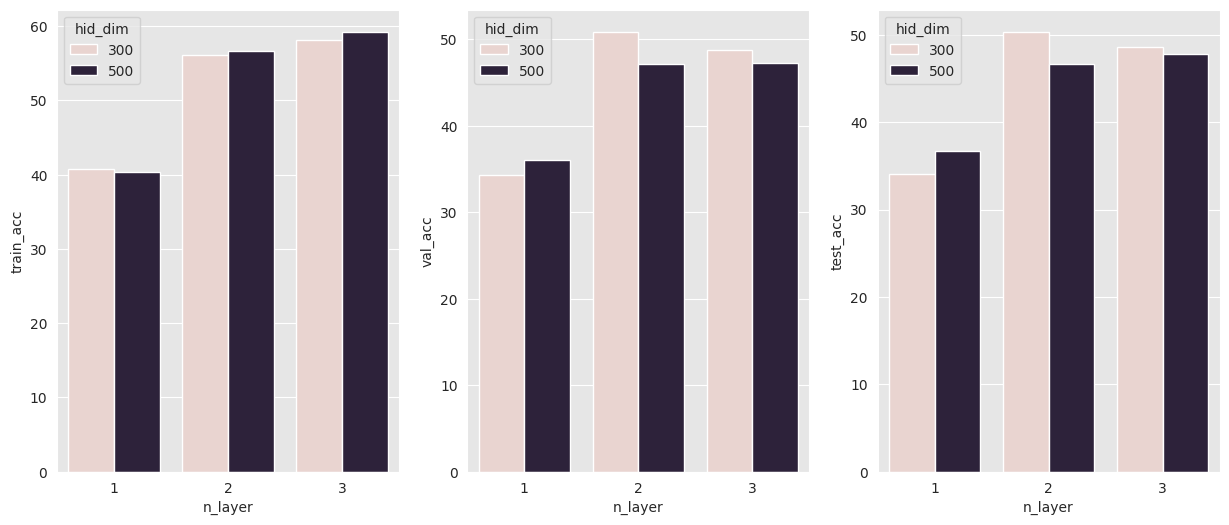

In [ ]:
result = load_exp_result('exp1')

# epoch이 끝났을때 최종 acc 값 비교하기 (train/validate/test)
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {'axes.facecolor' : ".9"})

sns.barplot(x = 'n_layer', y ='train_acc', hue='hid_dim', data=result, ax=ax[0])
sns.barplot(x = 'n_layer', y ='val_acc', hue='hid_dim', data=result, ax=ax[1])
sns.barplot(x = 'n_layer', y ='test_acc', hue='hid_dim', data=result, ax = ax[2])
plt.show()

In [ ]:
df

,type,loss,epoch,n_layer,hid_dim
0,train,1.879114,0,3,500
1,train,1.577562,1,3,500
2,train,1.473500,2,3,500
3,train,1.404558,3,3,500
4,train,1.344191,4,3,500
...,...,...,...,...,...
115,val,1.827331,5,1,300
116,val,1.877073,6,1,300
117,val,1.786669,7,1,300
118,val,1.794862,8,1,300


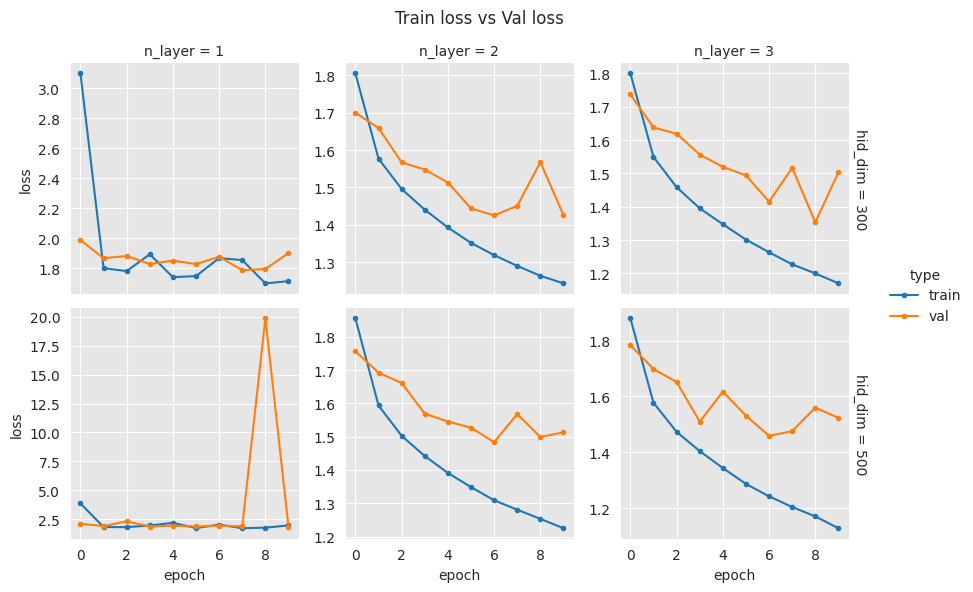

In [ ]:
# 각 실험에서 epoch에 따른 loss의 변화 확인
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')

# 실험한 종류
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()

list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)



# row를 'hid_dim' 변수로 나누고, col을 'n_layer' 변수로 나누어서 grid를 생성
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)

# 각 grid에 x축은 'epoch', y축은 'loss'로 선 그래프를 그림. marker='.'로 각 점을 표시
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)
plt.show()

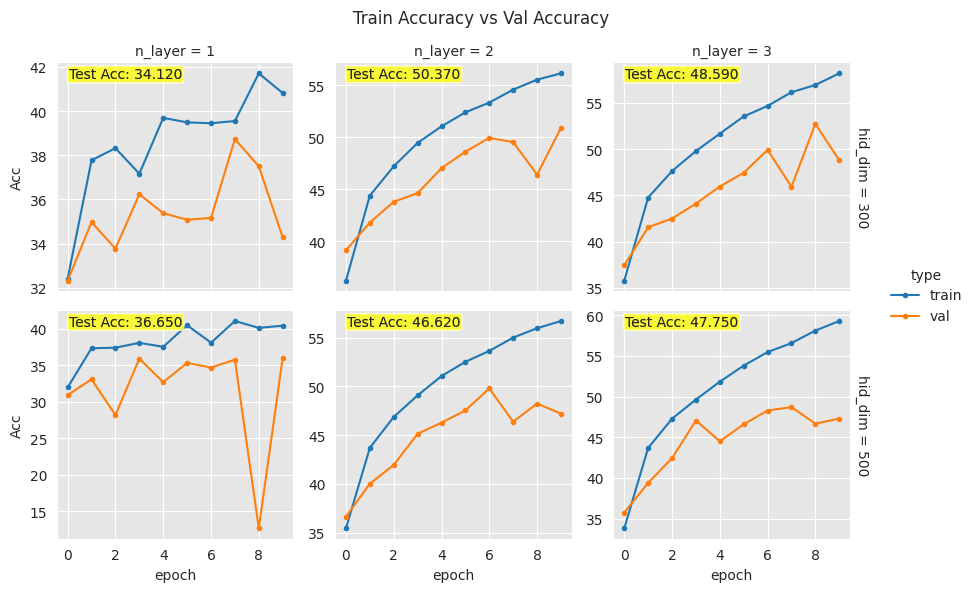

In [ ]:
# epoch에 따른 Acc 확인
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]

        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')

plt.subplots_adjust(top=0.89)

plt.show()